# Pipeline de Aprendizado de Máquina para Aprovação de Crédito

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# Leitura dos dados
df_train = pd.read_csv("./Dataset/conjunto_de_treinamento.csv")
df_test = pd.read_csv("./Dataset/conjunto_de_teste.csv")

test_id_solicitante = df_test["id_solicitante"]

## 1. Análise Exploratória de Dados

Formato do dataset de treino: (20000, 42)
Variáveis com mais valores ausentes:
grau_instrucao_companheiro    0.64300
profissao_companheiro         0.57570
profissao                     0.15485
ocupacao                      0.14890
meses_na_residencia           0.07250
dtype: float64


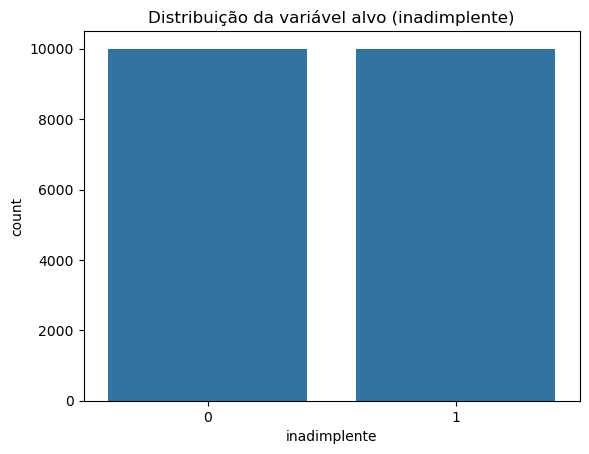

In [2]:

print("Formato do dataset de treino:", df_train.shape)
print("Variáveis com mais valores ausentes:")
print(df_train.isnull().mean().sort_values(ascending=False).head())

sns.countplot(x="inadimplente", data=df_train)
plt.title("Distribuição da variável alvo (inadimplente)")
plt.show()


## 2. Limpeza dos Dados

In [3]:

colunas_ignoradas = [
    "id_solicitante", "grau_instrucao", "possui_telefone_celular",
    "qtde_contas_bancarias_especiais", "meses_no_trabalho",
    "profissao_companheiro", "grau_instrucao_companheiro"
]

df_train.drop(columns=colunas_ignoradas, inplace=True)
df_test.drop(columns=colunas_ignoradas, inplace=True)


## 3. Inputação de Valores Faltantes

In [4]:

colunas_numericas = ["renda_mensal_regular", "renda_extra"]
colunas_categoricas = [col for col in df_train.columns if col not in colunas_numericas + ["inadimplente"]]

X = df_train.drop("inadimplente", axis=1)
y = df_train["inadimplente"]

preprocessador = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), colunas_numericas),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), colunas_categoricas)
])


## 4. Feature Engineering

In [5]:
X["renda_total"] = X["renda_mensal_regular"].fillna(0) + X["renda_extra"].fillna(0)
df_test["renda_total"] = df_test["renda_mensal_regular"].fillna(0) + df_test["renda_extra"].fillna(0)
colunas_numericas.append("renda_total")

X["tem_renda_extra"] = (X["renda_extra"] > 0).astype(int)
df_test["tem_renda_extra"] = (df_test["renda_extra"] > 0).astype(int)
colunas_categoricas.append("renda_total")

cartao_cols = ["possui_cartao_visa", "possui_cartao_mastercard", 
                "possui_cartao_diners", "possui_cartao_amex", "possui_outros_cartoes"]
X["total_cartoes"] = X[cartao_cols].sum(axis=1)
X["possui_cartao"] = (X["total_cartoes"] > 0).astype(int)
df_test["total_cartoes"] = df_test[cartao_cols].sum(axis=1)
df_test["possui_cartao"] = (df_test["total_cartoes"] > 0).astype(int)
colunas_categoricas.append("total_cartoes")
colunas_categoricas.append("possui_cartao")

X["idade_grupo"] = pd.cut(X["idade"], 
                                    bins=[0, 25, 35, 45, 55, 100], 
                                    labels=["jovem", "adulto_jovem", "adulto", "maduro", "senior"])
df_test["idade_grupo"] = pd.cut(df_test["idade"], 
                                    bins=[0, 25, 35, 45, 55, 100], 
                                    labels=["jovem", "adulto_jovem", "adulto", "maduro", "senior"])
colunas_categoricas.append("idade_grupo")

X["patrimonio_per_capita"] = (X["valor_patrimonio_pessoal"] / 
                                        (X["qtde_dependentes"] + 1))
df_test["patrimonio_per_capita"] = (df_test["valor_patrimonio_pessoal"] / 
                                        (df_test["qtde_dependentes"] + 1))
colunas_categoricas.append("patrimonio_per_capita")

## 5. Modelos e Hiperparâmetros

In [6]:

modelos = {
    "GradientBoosting": {
        "modelo": GradientBoostingClassifier(),
        "parametros": {
            "classificador__n_estimators": [50, 100],
            "classificador__learning_rate": [0.01, 0.1]
        }
    },
    "LogisticRegression": {
        "modelo": LogisticRegression(max_iter=5000),
        "parametros": {
            "classificador__C": [0.1, 1, 10],
            "classificador__penalty": ["l1", "l2"],
            "classificador__solver": ["liblinear"]
        }
    },
    "XGBoost": {
        "modelo": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "parametros": {
            "classificador__n_estimators": [50, 100],
            "classificador__learning_rate": [0.01, 0.1]
        }
    },
    "LightGBM": {
        "modelo": LGBMClassifier(),
        "parametros": {
            "classificador__n_estimators": [50, 100],
            "classificador__learning_rate": [0.01, 0.1]
        }
    },
    "RandomForest": {
        "modelo": RandomForestClassifier(),
        "parametros": {
            "classificador__n_estimators": [50, 100],
            "classificador__max_depth": [None, 10, 20]
        }
    },
    "DecisionTree": {
        "modelo": DecisionTreeClassifier(),
        "parametros": {
            "classificador__max_depth": [None, 10, 20],
            "classificador__min_samples_split": [2, 5, 10]
        }
    }
}

## 6. Busca de Hiperparâmetros com Cross Validation

In [ ]:

# resultados = []
# melhor_modelo = None
# melhor_score = 0

# for nome, cfg in modelos.items():
#     print(f"Treinando modelo: {nome}")
#     pipeline = Pipeline([
#         ("pre", preprocessador),
#         ("classificador", cfg["modelo"])
#     ])
#     grid = GridSearchCV(pipeline, cfg["parametros"], cv=StratifiedKFold(n_splits=3), scoring="accuracy")
#     grid.fit(X, y)
#     media = grid.best_score_
#     std = grid.cv_results_["std_test_score"][grid.best_index_]
#     print(f"Acurácia Média: {media:.4f} | Desvio: {std:.4f}")
#     resultados.append((nome, media, std))
#     if media > melhor_score:
#         melhor_score = media
#         melhor_modelo = (nome, grid.best_estimator_)


Treinando modelo: GradientBoosting
Acurácia Média: 0.5911 | Desvio: 0.0043
Treinando modelo: LogisticRegression
Acurácia Média: 0.5997 | Desvio: 0.0029
Treinando modelo: XGBoost
Acurácia Média: 0.5927 | Desvio: 0.0017
Treinando modelo: LightGBM
Acurácia Média: 0.5955 | Desvio: 0.0051
Treinando modelo: RandomForest
Acurácia Média: 0.5884 | Desvio: 0.0036
Treinando modelo: DecisionTree
Acurácia Média: 0.5733 | Desvio: 0.0032


In [18]:

resultados = []
melhor_modelo = None
melhor_score = 0
model_results = []

for nome, cfg in modelos.items():
    print(f"Treinando modelo: {nome}")
    pipeline = Pipeline([
        ("pre", preprocessador),
        ("classificador", cfg["modelo"])
    ])
    grid = GridSearchCV(pipeline, cfg["parametros"], cv=StratifiedKFold(n_splits=3), scoring="accuracy")
    grid.fit(X, y)
    media = grid.best_score_
    std = grid.cv_results_["std_test_score"][grid.best_index_]
    print(f"Acurácia Média: {media:.4f} | Desvio: {std:.4f}")
    resultados.append((nome, media, std))
    model_results.append([media, (nome, grid.best_estimator_)])
    if media > melhor_score:
        melhor_score = media
        melhor_modelo = (nome, grid.best_estimator_)


Treinando modelo: GradientBoosting
Acurácia Média: 0.5908 | Desvio: 0.0041
Treinando modelo: LogisticRegression
Acurácia Média: 0.5997 | Desvio: 0.0029
Treinando modelo: XGBoost
Acurácia Média: 0.5927 | Desvio: 0.0017
Treinando modelo: LightGBM
Acurácia Média: 0.5955 | Desvio: 0.0051
Treinando modelo: RandomForest
Acurácia Média: 0.5900 | Desvio: 0.0032
Treinando modelo: DecisionTree
Acurácia Média: 0.5734 | Desvio: 0.0026


## 7. Modelo com Melhor Desempenho

In [8]:

print(f"Melhor Modelo: {melhor_modelo[0]}")
print(f"Acurácia: {melhor_score:.4f}")


Melhor Modelo: LogisticRegression
Acurácia: 0.5997


## 8. Predição Final no Conjunto de Teste

In [9]:
# Previsões com melhor modelo
y_pred = melhor_modelo[1].predict(df_test)

# Gerar arquivo de submissão
df_submission = pd.DataFrame({
    "id_solicitante": test_id_solicitante,
    "inadimplente": y_pred
})

df_submission.to_csv("arquivo_submissao.csv", index=False)
df_submission.head()

,id_solicitante,inadimplente
0,20001,1
1,20002,1
2,20003,1
3,20004,0
4,20005,0


In [21]:
model_results_ordered = sorted(model_results, key=lambda x: x[0], reverse=True)
for i in range(1, len(model_results_ordered)):
    try:
        # Previsões com ith model
        ith_model = model_results_ordered[i][1]
        y_pred = ith_model[1].predict(df_test)

        # Gerar arquivo de submissão
        df_submission = pd.DataFrame({
            "id_solicitante": test_id_solicitante,
            "inadimplente": y_pred
        })

        df_submission.to_csv(f"arquivo_submissao_{i}.csv", index=False)
        df_submission.head()
    except:
        print(f"i = {i}")